# Looping, part 6: Day 3 highs??

I'm looking into whether the highs I've noticed a couple of times on the third day of Alma's insulin pump have been happening consistently, or if it's just a total coincidence.

In this notebook, I am comparing blood glucose data vs pod age using both Omnipod 5 and Looping. 

TL;DR Here's the final plot.

![o5_and_loop](https://gist.github.com/assets/1017259/5554ff2a-6e11-4f9f-8606-b06186fe2fcc)

In [1]:
import sys
sys.path.append("../")

from mdb_tools import load_data as ld
from mdb_tools import schemas
from mdb_tools import loop_stats as oop
from mdb_tools import sugar_plots as sp

import pandas as pd
import numpy as np

from datetime import datetime
import pytz

import matplotlib.pyplot as plt
%matplotlib widget

import hvplot.pandas
#hvplot.extension('bokeh', 'matplotlib')  

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


So this is just a little aside I guess, but as I work through these little exploration exercises, I keep running the same code over and over. So if I'm noticing I'm repeating the same things it seems like an obvious opportunity to write a function and same some space and some time. Not doing the function yet (bc I'm impatient to look at the day 3 highs!) but I am at least going to pull all the possible "function" stuff into one cell.

In [2]:
# Things that may change (ie eventual function arguments)
yml_secrets_file = '../../secrets/mdb_secrets.yml'
time_zone = 'US/Eastern'

# Access the database using the yml secrets file, and get a specific set of "collections"
col_entries, col_treatments, col_profile, col_devicestatus = ld.get_collections(yml_secrets_file)

# Grab schemas
entries_schema, treatments_schema, devicestatus_schema = schemas.mdb_schemas()

# Load
df_entries0 = col_entries.find_pandas_all({}, schema=entries_schema)
df_treatments = col_treatments.find_pandas_all({}, schema=treatments_schema)
df_devicestatus = col_devicestatus.find_pandas_all({}, schema=devicestatus_schema)

# Remove duplicate entries from cgm date - keep only loop for now.
df_entries = df_entries0[df_entries0["device"]=="loop://Dexcom/G6/21.0"].copy()

# Convert entries time strings to datetime format 
df_entries["time"] = pd.to_datetime(df_entries["dateString"]).dt.tz_convert(time_zone)
df_entries.set_index("time", inplace = True, drop=False)
df_entries.sort_index(inplace=True)

# Convert device status time strings to datetime format
df_devicestatus["time"] = pd.to_datetime(df_devicestatus["created_at"]).dt.tz_convert(time_zone)

In [3]:
df_entries.tail()

,sgv,dateString,date,device,time
time,,,,,
2023-12-17 19:46:55-05:00,199.0,2023-12-18T00:46:55.000Z,1702860415980,loop://Dexcom/G6/21.0,2023-12-17 19:46:55-05:00
2023-12-17 19:51:55-05:00,191.0,2023-12-18T00:51:55.000Z,1702860715886,loop://Dexcom/G6/21.0,2023-12-17 19:51:55-05:00
2023-12-17 19:56:55-05:00,183.0,2023-12-18T00:56:55.000Z,1702861015769,loop://Dexcom/G6/21.0,2023-12-17 19:56:55-05:00
2023-12-17 20:01:55-05:00,179.0,2023-12-18T01:01:55.000Z,1702861315427,loop://Dexcom/G6/21.0,2023-12-17 20:01:55-05:00
2023-12-17 20:06:55-05:00,167.0,2023-12-18T01:06:55.000Z,1702861615611,loop://Dexcom/G6/21.0,2023-12-17 20:06:55-05:00


In [4]:
pod_change_times = [x["time"] for xdex, x in df_devicestatus.iterrows() 
                    if x["pump"]['reservoir_display_override'] == 'Finish Pairing']

# Convert pod change times to unix
pod_times_unix = pd.Series(pod_change_times).view('int64').sort_values()

In [5]:
# Set up my start/end dates and start/end times
date_start = '2023-11-16'
date_end = '2023-12-16'

# start and end time in hours/time of day
time_start = 0
time_end = 24

# Extract only the dates of interest
df_sub = df_entries.loc[date_start:date_end].copy()

# make a column of just hour of day
df_sub["hour"] = df_sub.index.hour
df_sub["date"] = df_sub.index.date
df_sub["time_of_day"] = df_sub.index.time

# Set up color scale for date plotting
unq_dates = np.unique(df_sub.date)
date_dict = dict(zip(unq_dates, range(len(unq_dates))))
df_sub["date_color"] = df_sub["date"].map(date_dict)

# # Make another subset df that is just the requested hours
# df_req = df_sub[(df_sub["hour"] >= time_start) & (df_sub["hour"] <= time_end)]

# Convert requested input times to unix
in_times = df_sub.index.to_series()
in_times_unix = in_times.view('int64').sort_values()

In [6]:
# Get the indices of the most "recent" pod change times. Only keep the ones for the requested profile.
pod_idx = [(len([in_time - t for t_idx, t in enumerate(pod_times_unix) if
                 (in_time - t >= 0)]) - 1) for in_time in in_times_unix]

# Get the time since last pod change for each requested time
# pod_times_at_in_times = pod_change_times[pod_idx]
pod_times = [pod_change_times[p] for p in pod_idx]

df_sub["pod_times"] = pod_times

df_sub["pod_age_hours"] = (df_sub["time"] - df_sub["pod_times"]).dt.total_seconds()/3600

# Blood glucose vs pod age

This first plot is just the most basic - blood glucose ("sgv") vs pod age in hours. Not much to see here because all the points are overalapping. 

In [7]:
# hvplot.extension('matplotlib') # Comment this line to make it interactive

df_sub.hvplot.points(x="pod_age_hours", y="sgv")

:Points   [pod_age_hours,sgv]

We don't really want the extra data beyond 72 hours because those data aren't correct. It basically means that I missed a pod change indicator in the database. But I can assume that a pod change happened and just subtract 72 (or a multiple of 72 if need be) for pod ages beyond 72. It might not work all the time but it should work alright for us.

In [8]:
#hvplot.extension('matplotlib') # Comment this line to make it interactive

# A little modulo magic to just get the remainder 
df_sub["pod_age_hours_corr"] = [x % 72 for x in df_sub["pod_age_hours"]]

# And plot to see if it worked...
df_sub.hvplot.points(x="pod_age_hours_corr", y="sgv")

:Points   [pod_age_hours_corr,sgv]

In [9]:
# We only want just hours, and not decimal hours (for grouping later)
df_sub["pod_age_hours_floor"] = np.floor(df_sub["pod_age_hours_corr"])

df_sub.sort_values(by="pod_age_hours_floor", inplace=True)

## Point and line plot, colored by pod age

This one is mostly just to make sure I handled the pod age calculations correctly. It looks the way I expect - pod age increasing gradually and resetting every three days.

:Points   [time,sgv]   (hours_color)
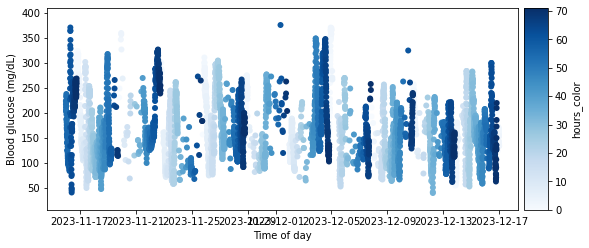

In [10]:
hvplot.extension('matplotlib') # Comment this line to make it interactive

# Set up color scale for hours plotting
unq_items = np.unique(df_sub.pod_age_hours_floor)
item_dict = dict(zip(unq_items, range(len(unq_items))))
df_sub["hours_color"] = df_sub["pod_age_hours_floor"].map(item_dict)

df_sub.hvplot.points(x='time', y='sgv', color="hours_color", cmap="Blues", 
                     ylabel="Blood glucose (mg/dL)", xlabel="Time of day")


## Boxplot with hourly bins

In this plot I'm grouping the data into hours to see if I can get a better view, using boxplot. I think that the main thing this plots shows is a twice-daily cycle that is probably more correlated with meals than with time since pod change. I think the focus is on the wrong scale in this case.


In [11]:
hvplot.extension('bokeh') # Comment this line to make it interactive

boxplot = df_sub.hvplot.box(y='sgv', by='pod_age_hours_floor', height=400, width=900, legend=False,
                           ylabel="Blood glucose (mg/dL)", xlabel="Pod age (hours)")
boxplot

:BoxWhisker   [pod_age_hours_floor]   (sgv)

## Boxplot - BG by day since pod change

This next one shows a really clear trend. It looks like there's definitely an increase over time as the pod is worn. I'm not sure exactly what may cause this but perhaps it's related to reduced insulin effectiveness over time (temperature related?) or maybe it's something else. I'm still not sure if other people are seeing this same pattern. 

My guess is that this is something that is accounted for in the Omnipod manufacturers algorithm. They do say that it takes a couple of pods when you first start for it to adjust and become more optimal for each person, so I suppose it's conceivable this is . 

In [12]:
hvplot.extension('bokeh') # Comment this line to make it interactive

pod_age_days = np.ceil(df_sub.groupby(["date"])[["pod_age_hours_corr"]].median()/24)
daily_bg = df_sub.groupby(["date"])[["sgv"]].mean()

df_daily = pd.DataFrame(data=daily_bg)
df_daily["pod_age_days"] = pod_age_days
df_daily = df_daily.sort_values(by="pod_age_days")

boxplot = (df_daily.hvplot.box(y='sgv', by='pod_age_days', height=300, width=600, legend=False,
                              ylabel="Blood glucose (mg/dL)", xlabel="Pod age (days)",
                              xlim=[0.5,3.5], ylim=[100,250])
           .opts(fontscale=1.5))
boxplot

:BoxWhisker   [pod_age_days]   (sgv)

# Compare with Glooko data (Omnipod 5)

In [13]:
import pickle

# Load the pickled data
pkl_file = r"../../data/glooko_cgm_and_pump.pkl"


with open(pkl_file, "rb") as file:
    df_cgm, df_alarms, pod_change_flag = pickle.load(file)

df_cgm.set_index("time", inplace = True, drop=False)

df_alarms.tail()

,Timestamp,Alarm/Event,Serial Number,time
216,2023-09-01 14:09,Glucose levels below configured threshold.,Insulet Omnipod 5,2023-09-01 14:09:00-04:00
217,2023-09-01 21:42,Recoverable PDM error.,Insulet Omnipod 5,2023-09-01 21:42:00-04:00
218,2023-09-02 18:39,Pod will expire at user set time,Insulet Omnipod 5,2023-09-02 18:39:00-04:00
219,2023-09-02 19:39,Pod is nearing expiration,Insulet Omnipod 5,2023-09-02 19:39:00-04:00
220,2023-09-03 16:14,Glucose levels below configured threshold.,Insulet Omnipod 5,2023-09-03 16:14:00-04:00


In [14]:
# Prep the pod change data
df_pod_change = df_alarms[df_alarms["Alarm/Event"] == pod_change_flag]

df_pod_change

,Timestamp,Alarm/Event,Serial Number,time
0,2023-01-21 10:42,Pod will expire at user set time,Insulet Omnipod 5,2023-01-21 10:42:00-05:00
2,2023-01-24 10:04,Pod will expire at user set time,Insulet Omnipod 5,2023-01-24 10:04:00-05:00
5,2023-01-27 13:33,Pod will expire at user set time,Insulet Omnipod 5,2023-01-27 13:33:00-05:00
8,2023-02-02 09:30,Pod will expire at user set time,Insulet Omnipod 5,2023-02-02 09:30:00-05:00
12,2023-02-05 13:56,Pod will expire at user set time,Insulet Omnipod 5,2023-02-05 13:56:00-05:00
...,...,...,...,...
201,2023-08-21 19:39,Pod will expire at user set time,Insulet Omnipod 5,2023-08-21 19:39:00-04:00
205,2023-08-24 19:06,Pod will expire at user set time,Insulet Omnipod 5,2023-08-24 19:06:00-04:00
210,2023-08-27 18:28,Pod will expire at user set time,Insulet Omnipod 5,2023-08-27 18:28:00-04:00
214,2023-08-30 17:53,Pod will expire at user set time,Insulet Omnipod 5,2023-08-30 17:53:00-04:00


In [15]:
pod_change_times = df_pod_change["time"].to_list()

# Convert pod change times to unix
pod_times_unix = pd.Series(pod_change_times).view('int64').sort_values()

# Set up my start/end dates and start/end times
date_start = '2023-08-03'
date_end = '2023-09-03'

# start and end time in hours/time of day
time_start = 0
time_end = 24

# Extract only the dates of interest
df_sub_glooko = df_cgm.loc[date_start:date_end].copy()

# make a column of just hour of day
df_sub_glooko["hour"] = df_sub_glooko.index.hour
df_sub_glooko["date"] = df_sub_glooko.index.date
df_sub_glooko["time_of_day"] = df_sub_glooko.index.time

# Set up color scale for date plotting
unq_dates = np.unique(df_sub_glooko.date)
date_dict = dict(zip(unq_dates, range(len(unq_dates))))
df_sub_glooko["date_color"] = df_sub_glooko["date"].map(date_dict)

# Convert requested input times to unix
in_times = df_sub_glooko.index.to_series()
in_times_unix = in_times.view('int64').sort_values()

# Get the indices of the most "recent" pod change times. Only keep the ones for the requested profile.
pod_idx = [(len([in_time - t for t_idx, t in enumerate(pod_times_unix) if
                 (in_time - t >= 0)]) - 1) for in_time in in_times_unix]

# Get the time since last pod change for each requested time
# pod_times_at_in_times = pod_change_times[pod_idx]
pod_times = [pod_change_times[p] for p in pod_idx]

df_sub_glooko["pod_times"] = pod_times

df_sub_glooko["pod_age_hours"] = (df_sub_glooko["time"] - df_sub_glooko["pod_times"]).dt.total_seconds()/3600

# A little modulo magic to just get the remainder 
df_sub_glooko["pod_age_hours_corr"] = [x % 72 for x in df_sub_glooko["pod_age_hours"]]

# We only want just hours, and not decimal hours (for grouping later)
df_sub_glooko["pod_age_hours_floor"] = np.floor(df_sub_glooko["pod_age_hours_corr"])


In [16]:
hvplot.extension('bokeh') # Comment this line to make it interactive

pod_age_days = np.ceil(df_sub_glooko.groupby(["date"])[["pod_age_hours_corr"]].median()/24)
daily_bg = df_sub_glooko.groupby(["date"])[["bg"]].mean()

df_daily_glooko = pd.DataFrame(data=daily_bg)
df_daily_glooko["pod_age_days"] = pod_age_days
df_daily_glooko.sort_values(by="pod_age_days", inplace=True)

boxplot = df_daily_glooko.hvplot.box(y='bg', by='pod_age_days', height=300, width=600, legend=False,
                                  ylabel="Blood glucose (mg/dL)", xlabel="Pod age (days)",
                                  xlim=[0.5,3.5]).opts(fontscale=1.5)
boxplot

:BoxWhisker   [pod_age_days]   (bg)

## Plotting Loop and Omnipod together

In [17]:

boxplot = (df_daily_glooko.hvplot.box(y='bg', by='pod_age_days', height=300, width=350, legend=False,
                                      ylabel="Blood glucose (mg/dL)", xlabel="Pod age (days)",
                                      title="Omnipod 5",
                              xlim=[0.5,3.5], ylim=[100,250]).opts(fontscale=1.5) +
           df_daily.hvplot.box(y='sgv', by='pod_age_days', height=300, width=300, legend=False,
                               ylabel="Blood glucose (mg/dL)", xlabel="Pod age (days)", yaxis=False,
                               title="DIY Loop",
                               xlim=[0.5,3.5], ylim=[100,250]).opts(shared_axes=True, fontscale=1.5)).cols(2)
boxplot

:Layout
   .BoxWhisker.I  :BoxWhisker   [pod_age_days]   (bg)
   .BoxWhisker.II :BoxWhisker   [pod_age_days]   (sgv)